Rerun ml experiments on VQ-BGU VQ-BDU 

In [1]:
import pandas as pd

bgu = pd.read_csv('./takeoff-merged-VQ-BGU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])
bdu = pd.read_csv('./takeoff-merged-VQ-BDU-30s.csv', parse_dates=['reportts']).dropna(subset=['egtm'])

fleet = ['VQ-BGU', 'VQ-BDU']

dataset = pd.concat([bgu, bdu]) \
  .drop(columns=['file_path', 'reason']) \
  .sort_values('reportts')

dataset = dataset[dataset['acnum'].isin(fleet)].dropna(subset=['egtm'])

In [2]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.linear_model import Ridge
from gui.utils import *
import numpy as np

def train_model(X, y, model = 'linreg', alpha=0.2):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  if model == 'catboost':
    model = GradientBoostingRegressor(n_estimators=300)
  else:
    model = Ridge(alpha=alpha)

  model.fit(X_train, y_train)

  predicted_train = model.predict(X_train)
  predicted_test = model.predict(X_test)

  metrics = get_metrics(y_test, predicted_test)
  pred = np.concatenate([predicted_train, predicted_test])
  all_smooth = smooth(pred)
  smooth_metrics = get_metrics(y_test, all_smooth[train_i:])

  return metrics, smooth_metrics, model, predicted_train, predicted_test, train_i, y_test

### 1. Linear regression on subset of features

In [38]:
adj_features = [
  'hpcbf', 'ff', 'nait', 'fmvc', 'tn', 'p2e', 'sva', 'lpbt', 'gle', 'tfuel', 
  'tat',  'ffr', 'n1p', 'cas', 'vorrc', 'n2c5', 'joip', 'lpt', 'n2a', 'hpctc', 'n2p', 
  'lpcsv', 'pf', 'gw', 'n1c2', 'ttp', 'ps14', 'nai', 'fvd', 'lpctc', 'foc', 'cg', 'w14'
]

data = dataset.copy(deep=False).reset_index()
X = data[adj_features].fillna(0)
y = data['egtm']

metrics, metrics_smooth, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y, alpha=50)

pd.DataFrame([
  metrics, metrics_smooth
])

,rmse,mae,r2,mape
0,4.54317,3.00811,-2.69688,0.15098
1,3.41279,2.57211,-1.08611,0.13192


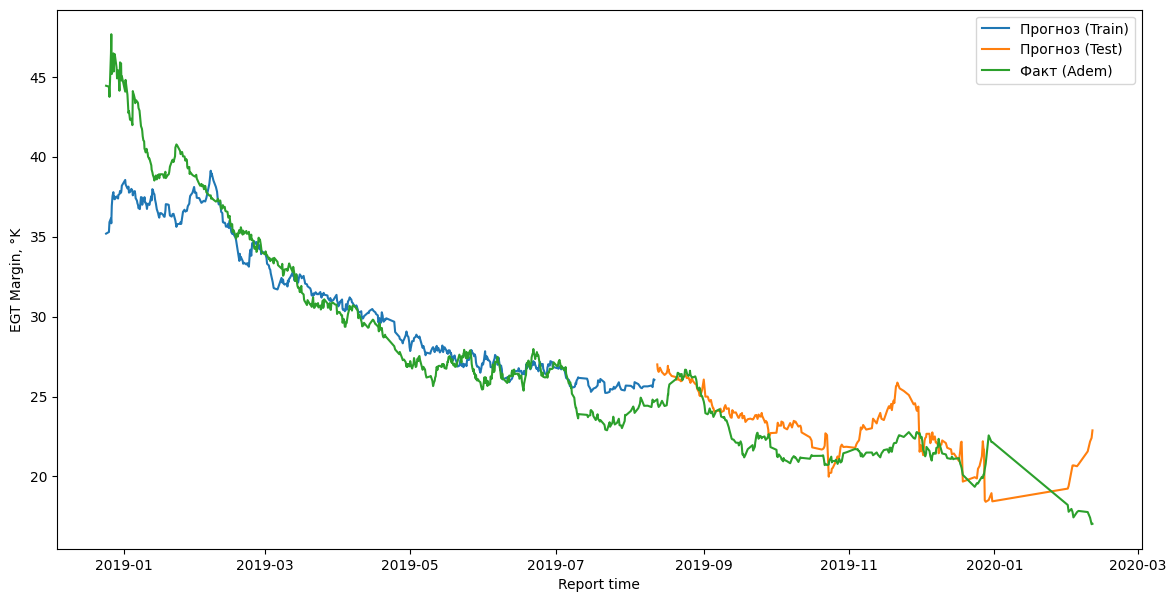

In [39]:
plot_predictions(data.reset_index(), 'VQ-BGU', 1, train_i, predicted_test, predicted_train, is_smooth=True, alpha=0.1)

### 2. Catboost on all features 

In [4]:
X = dataset.drop(columns=[
    'reportts', 'acnum', 'pos', 'dep', 'arr', 
    'egtm', 'fltdes', 'reportts',
    'dmusw', 'exswpn'
]).fillna(-100)

X = X.loc[:, ~X.columns.str.contains('stw')]
y = data['egtm']

metrics, metrics_smooth, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y, model='catboost')

pd.DataFrame([
  metrics, metrics_smooth
])

,rmse,mae,r2,mape
0,9.44561,7.23668,-14.98003,0.36759
1,9.05712,7.11592,-13.69257,0.36063


In [5]:
def plot_predictions(data, acnum, pos, train_i, predicted_test, predicted_train, is_smooth=True, figsize=(14, 7), title=None, alpha=1/10):
  data.loc[:train_i-1, 'pred_train'] = predicted_train
  data.loc[train_i:, 'pred_test'] = predicted_test

  sub = data[(data['acnum'] == acnum) & (data['pos'] == pos)]
  train_i2 = sub['pred_train'].count()

  plt.figure(figsize=figsize)

  if is_smooth:
    plt.plot(sub['reportts'][:train_i2], smooth(sub['pred_train'][:train_i2], alpha=alpha), '-')
    plt.plot(sub['reportts'], smooth(sub['pred_test'], alpha=alpha), '-')
  else:
    plt.scatter(sub['reportts'][:train_i2], sub['pred_train'][:train_i2], s=2)
    plt.scatter(sub['reportts'],  sub['pred_test'], s=2)

  plt.plot(sub['reportts'], sub['egtm'], '-', color='#2ca02c')

  plt.ylabel("EGT Margin, °K")
  plt.xlabel("Report time")
  # plt.title(f'Модель EGTM, acnum = {acnum}, pos = {pos}' if title is None else title)
  plt.legend(['Прогноз (Train)', 'Прогноз (Test)', 'Факт (Adem)'])
  plt.show()


### 3. Linear regression on gaspath features

In [6]:
selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat', 'n1a_peak', 'n2a_peak', 'ff', 'egt_peak', 'nf']

X = data[selected_params].fillna(0).reset_index()
y = data['egtm']

metrics, metrics_smooth, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y, alpha=50)

pd.DataFrame([
  metrics, metrics_smooth
])


,rmse,mae,r2,mape
0,2.86898,2.19431,-0.47426,0.10640
1,2.49521,1.97357,-0.11515,0.09508


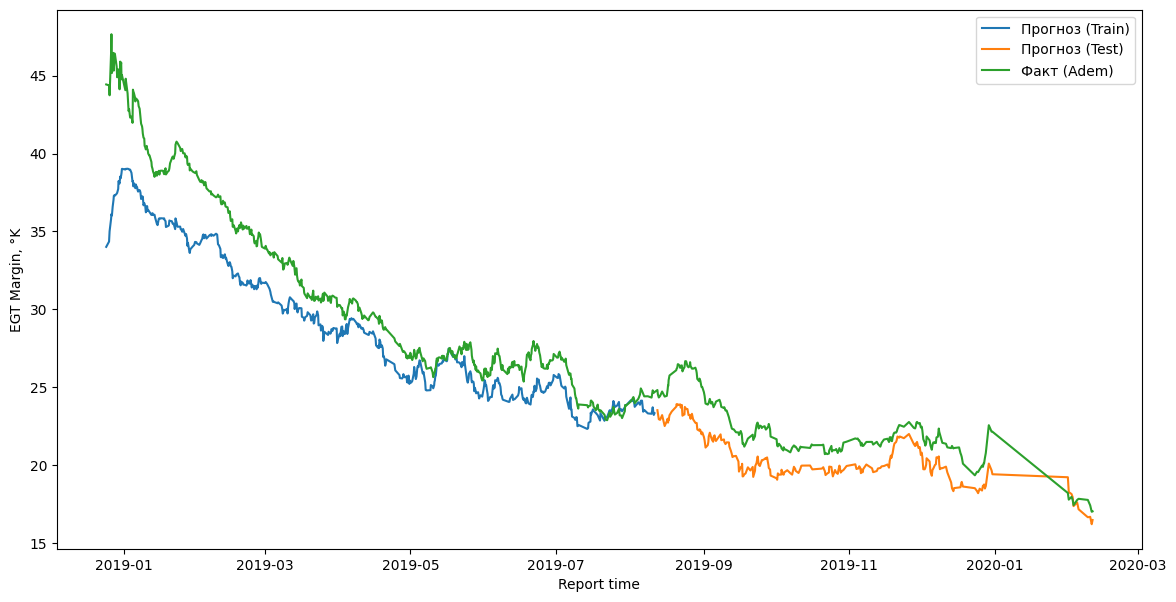

In [7]:
plot_predictions(data, 'VQ-BGU', 1, train_i, predicted_test, predicted_train, is_smooth=True)

### 4. Gaspath features + parameter corrections

In [8]:
selected_params = ['wai', 'nai', 'prv', 'hpv', 'xf', 'alt', 'mn', 'tat_peak', 'p2e', 'n1', 'n1a', 'n1a_peak', 'n2a', 'n2a_peak', 'ff', 'egt', 'egt_peak', 'nf']

corrected = correct(data[selected_params])

selected_corrected = ['nai', 'prv', 'n1a_peak_k', 'n2a_peak_k', 'ffk', 'egt_peak_k']

X = corrected[selected_corrected].fillna(0).reset_index()
y = data['egtm']

metrics, metrics_smooth, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y, alpha=50)

pd.DataFrame([
  metrics, metrics_smooth
])


,rmse,mae,r2,mape
0,2.74180,2.14813,-0.34644,0.10420
1,2.37301,1.92178,-0.00859,0.09257


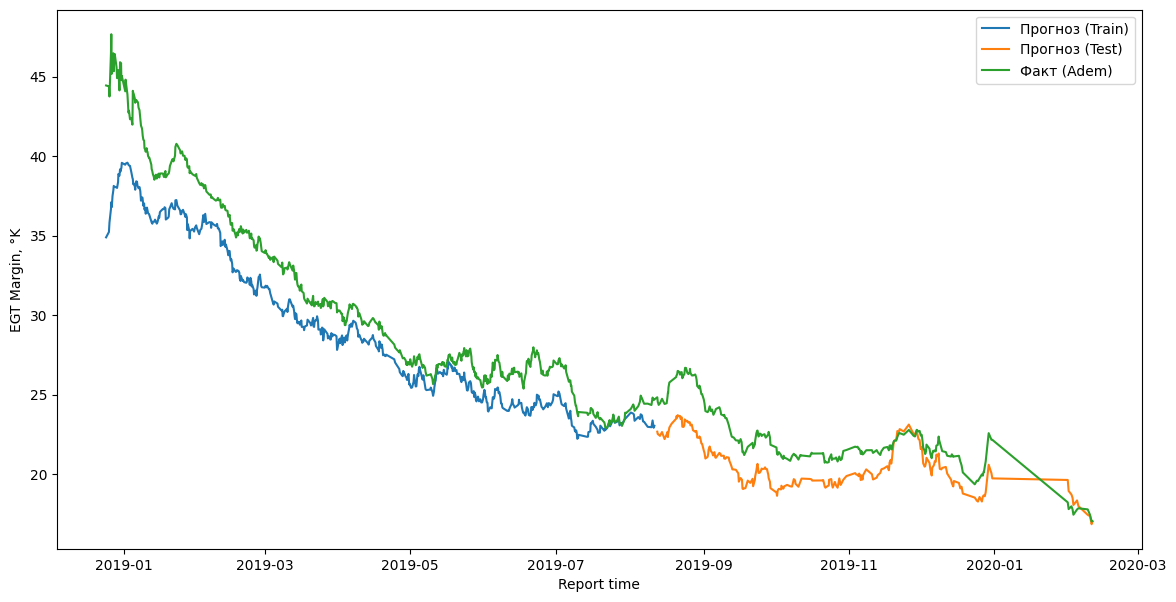

In [9]:
plot_predictions(data, 'VQ-BGU', 1, train_i, predicted_test, predicted_train, is_smooth=True)

### 5. Recursive features

In [10]:

selected_corrected = ['nai', 'prv', 'n1a_peak_k', 'n2a_peak_k', 'ffk', 'egt_peak_k']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

X_recursive = get_recursive_features([
  correct(bgu)[selected_corrected + y_cols + meta_cols], 
  correct(bdu)[selected_corrected + y_cols + meta_cols]
], n_back=16, features=selected_corrected)


X = X_recursive.drop(columns=(y_cols + meta_cols))
y = data['egtm']

metrics, metrics_smooth, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y, alpha=50)

pd.DataFrame([
  metrics, metrics_smooth
])


,rmse,mae,r2,mape
0,1.51595,1.15411,0.58839,0.05735
1,1.81519,1.44249,0.40985,0.07296


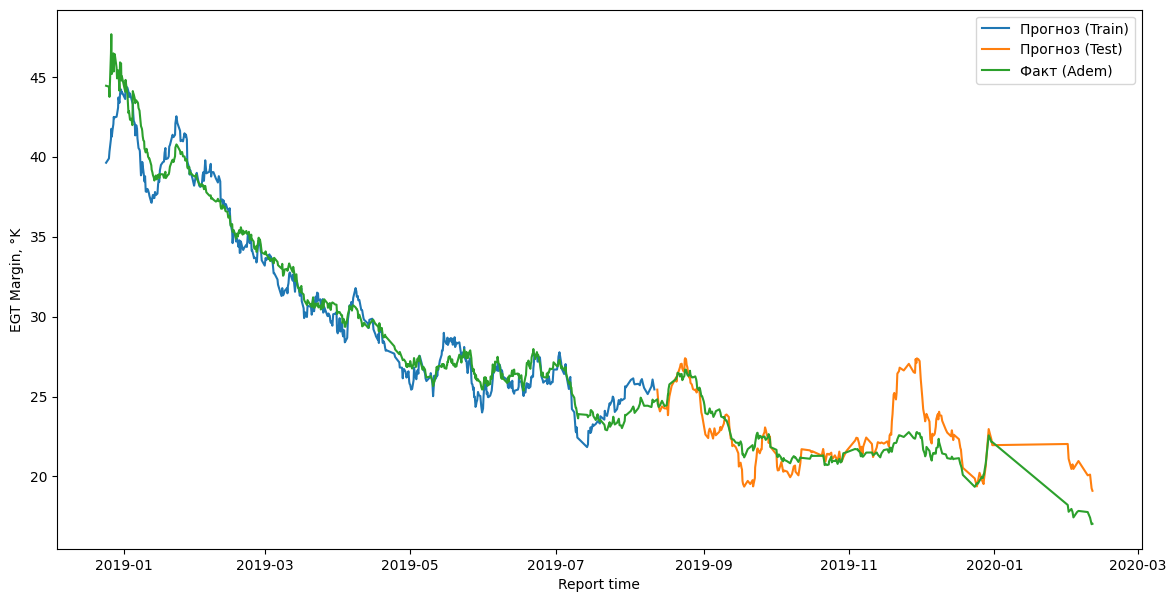

In [11]:
plot_predictions(data, 'VQ-BGU', 1, train_i, predicted_test, predicted_train, is_smooth=True, alpha=0.9)

### Effect of overfitting: 3 engines for train, 1 for test

In [12]:
selected_corrected = ['nai', 'prv', 'n1a_peak_k', 'n2a_peak_k', 'ffk', 'egt_peak_k']
y_cols = ['egtm']
meta_cols = ['reportts', 'acnum', 'pos']

X_train = get_recursive_features([
  correct(bgu)[selected_corrected + y_cols + meta_cols], 
  correct(bdu.query('pos == 1'))[selected_corrected + y_cols + meta_cols]
], n_back=10, features=selected_corrected)

X = X_train.drop(columns=(y_cols + meta_cols))
y = X_train['egtm']

metrics, metrics_smooth, model, predicted_train, predicted_test, train_i, y_test = train_model(X, y, alpha=50)

X_val = get_recursive_features([
  correct(bgu.query('pos == 1'))[selected_corrected + y_cols + meta_cols]
], n_back=10, features=selected_corrected)

y_val = X_val['egtm']

y_pred = model.predict(X_val.drop(columns=(y_cols + meta_cols)))


get_metrics(y_val, y_pred)


{'rmse': 1.5815, 'mae': 1.18395, 'r2': 0.94267, 'mape': 0.04406}

### 4. PRV Split

In [13]:
from sklearn.linear_model import Ridge
from typing import List

def predict_ensemble(models: List[Ridge], X: pd.DataFrame, field='nai'):
  pred = pd.DataFrame(index=X.index.copy(), columns=['pred'])
  for val in [True, False]:
    index = (X[field] == val)
    pred.loc[index, 'pred'] = models[val].predict(X[index])
  return pred

def filter_split_by_field(X: pd.DataFrame, y: pd.DataFrame, field: str, value: bool):
  return X[X[field] == value], y[X[field] == value]

def train_ensemble_model(X, y, model = 'linreg', field = 'nai'):
  assert len(X) == len(y)
  train_i = int(len(X) * 75 / 100)
  X_train, y_train = X[0:train_i], y[0:train_i]
  X_test, y_test = X[train_i:], y[train_i:]

  ensemble = dict()
  ensemble[True] = Ridge()
  ensemble[False] = Ridge()

  for val in [True, False]:
    X_train_f, y_train_f = filter_split_by_field(X_train, y_train, field, val)
    ensemble[val].fit(X_train_f, y_train_f)
  
  predicted_train = predict_ensemble(ensemble, X_train, field)

  predicted_test = predict_ensemble(ensemble, X_test, field)

  return get_metrics(y_test, predicted_test), model, predicted_train, predicted_test, train_i, y_test

In [40]:

selected_corrected = ['prv', 'n1a_peak_k', 'n2a_peak_k', 'ffk', 'egt_peak_k']

X_recursive = get_recursive_features([
  correct(bgu)[selected_corrected + y_cols + meta_cols], 
  correct(bdu)[selected_corrected + y_cols + meta_cols]
], n_back=16, features=selected_corrected)


X = X_recursive.drop(columns=(y_cols + meta_cols))
y = data['egtm']

metrics, model, predicted_train, predicted_test, train_i, y_test = train_ensemble_model(X, y, field='prv')

print(f'NAI ensemble: {metrics}')


NAI ensemble: {'rmse': 1.5207, 'mae': 1.14267, 'r2': 0.58581, 'mape': 0.05678}


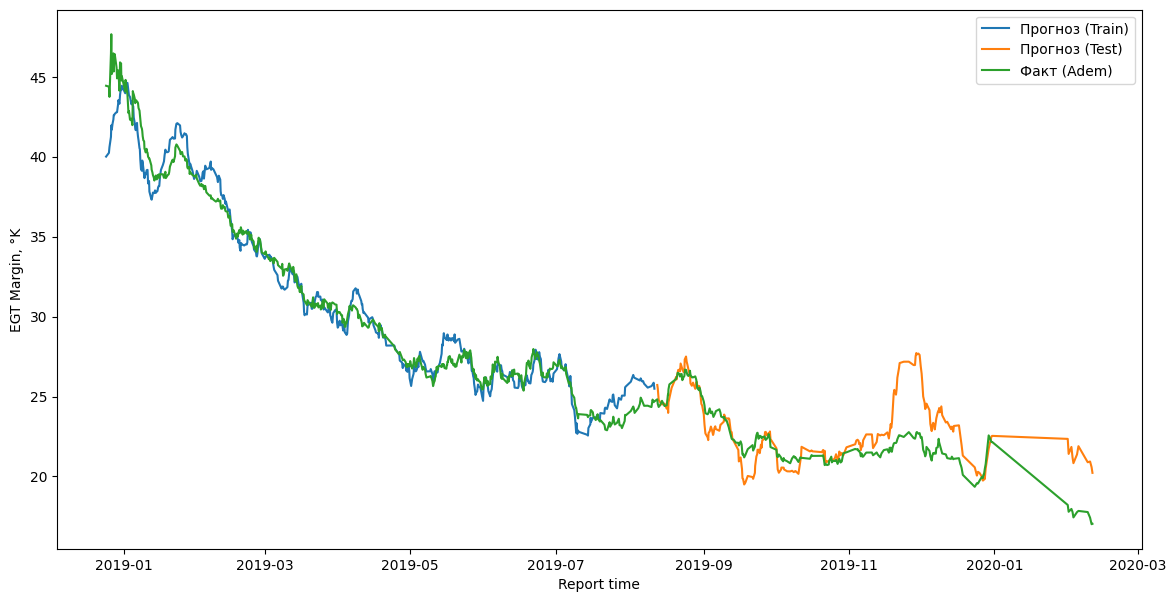

In [47]:
plot_predictions(data, 'VQ-BGU', 1, train_i, predicted_test['pred'], predicted_train['pred'], is_smooth=True, alpha=0.6)